<a href="https://colab.research.google.com/github/Bantami/All-Optical-QPM/blob/main/Colab/lff_pretrained_model_inference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colab Setting up Scripts


*   Downloading repository, dataset and models
*   Install pip packages


In [1]:
!git clone https://github.com/Bantami/All-Optical-QPM.git

!chmod 755 All-Optical-QPM/colab_setup.sh
!All-Optical-QPM/colab_setup.sh

Cloning into 'All-Optical-QPM'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 62 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (62/62), done.
     |████████████████████████████████| 631 kB 7.4 MB/s 
     |████████████████████████████████| 232 kB 3.8 MB/s 
     |████████████████████████████████| 49.9 MB 47 kB/s 
Downloading...
From: https://drive.google.com/uc?id=1ickDfs6bA-YM7RQSaMPRqFnC7YApjW8e
To: /content/hela.zip
100% 303M/303M [00:02<00:00, 136MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tHBWjNJPRHf1VX0XJicLIKs8av43_TPz
To: /content/models.zip
100% 3.27M/3.27M [00:00<00:00, 270MB/s]


### Import Libraries

In [2]:
import sys
sys.path.append('All-Optical-QPM')


from torch import nn
from collections import OrderedDict
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from torchvision import datasets, transforms
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import glob
import os
import json

from modules.dataloaders import *
from modules.diffraction import *
from modules.fourier_model import *
from modules.eval_metrics import *
from modules.vis_utils import *

## Use Pretrained Models: Model Selection and Loading

In [3]:
pretrained_models = {
    'MNIST'       : 'MNIST_lff',
    'HeLa [0,Pi]' : 'Hela_pi_lff',
    'HeLa [0,2Pi]': 'Hela_2pi_lff',

} 

# Selecting a pretrained model
data_type = 'HeLa [0,Pi]' 
model = pretrained_models[data_type]

In [4]:
folder = 'models/'

model_name = f'{model}.pth'

saved = torch.load(folder + model_name) # Loading pretrained model

cfg   = saved['cfg']

if data_type == 'HeLa [0,2Pi]': # Renaming layer number due to the incompatibility in the layer number in the pretrained model with the current fourier_model layer naming convention 
    temp_dict = OrderedDict()
    keys = saved['state_dict'].keys()
    for key in keys:
        if 'layer_blocks' in key:
            temp_dict['layer_blocks.0.'+key[15:]] = saved['state_dict'][key]
        else:
            temp_dict[key] = saved['state_dict'][key]
            
    saved['state_dict'] = temp_dict

In [5]:
if data_type == 'HeLa [0,2Pi]':
    cfg['model'] = 'fourier_model'

model = eval(cfg['model'])(cfg).to(cfg['device'])
model.load_state_dict(saved['state_dict'])
model.eval()

Learnable transmission coefficient: Amplitude and Phase
loading weights ... 


fourier_model(
  (layer_blocks): ModuleList(
    (0): fourier_layer()
  )
)

### Loading Configs

In [6]:
torch.manual_seed(cfg['torch_seed'])

shrinkFactor = cfg['shrink_factor'] if 'shrink_factor' in cfg else 1
img_size     = cfg['img_size']
angle_max    = eval(cfg['angle_max'])
inp_circular = cfg['input_circular'] if 'input_circular' in cfg.keys() else False # If the input field is propagated through a circular aperture
device = cfg['device']
    
if inp_circular: # Creating a circular mask to apply on the input
    rc = (img_size//2)//shrinkFactor
    xc = torch.arange(-img_size//2,img_size//2,1) 
    xc = torch.tile(xc, (1,img_size)).view(img_size,img_size).to(torch.cfloat)

    yc = torch.arange(img_size//2,-img_size//2,-1).view(img_size,1)
    yc = torch.tile(yc, (1,img_size)).view(img_size,img_size).to(torch.cfloat)

    circ = (abs(xc)**2 + abs(yc)**2 <= (rc)**2).to(torch.float32).view(1,img_size,img_size).to(device)
else:
    circ = torch.ones(1,img_size,img_size).to(device)

if(shrinkFactor!=1):
    # To obtain the starting position and ending position of the original image within the padded image 
    csize = int(img_size/shrinkFactor)
    spos  = int((img_size - csize)/2)
    epos  = spos + csize
else:
    spos = 0
    epos = img_size
    
dataloader = eval(cfg['get_dataloaders'])
print(cfg['get_dataloaders'])

train_loader, val_loader =  dataloader(cfg['img_size'], cfg['train_batch_size'], cfg['torch_seed'],  task_type= cfg['task_type'], shrinkFactor = shrinkFactor, cfg = cfg)
print(len(val_loader))

get_qpm_np_dataloaders
68


### Run Inference on unseen data

In [7]:
ssim_scores = []

for idx, (x, y) in enumerate(val_loader):  # Test loop 
    gt = x[:,0].to(cfg['device']) * circ # Groung truth image (input)
    pred_img,out_scale = model(gt) 

    
    pred_img = pred_img[:,spos:epos,spos:epos] # Crop the reconstructed image
    gt       = gt[:,spos:epos,spos:epos]       # Crop the groundtruth image
    
    pred_out = out_scale * pred_img.abs()**2

    if(cfg['get_dataloaders']=="get_mnist_dataloaders"):
        gt_angle = ((gt.angle()%(2*np.pi))/angle_max)
    else:
        # CLIP ANGLE TO -> [0, angle_max]
        y = torch.clip(y, min= 0, max= angle_max).to(device) * circ
        gt_angle = y[:,0].to(cfg['device'])[:,spos:epos,spos:epos] / angle_max
        
    pred_out = pred_out.to(torch.float32)
    ssim_scores.append(ssim_pytorch(pred_out, gt_angle, k= 11,range_independent=False))
    

print("Mean SSIM = ", np.mean(ssim_scores))

Mean SSIM =  0.7216695867040578


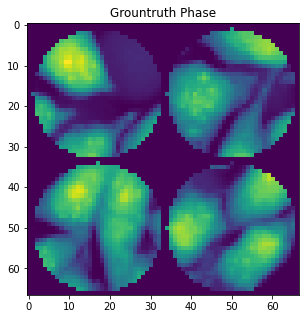

In [8]:
# Plotting ground truth images
gt_img_set = gt_angle.unsqueeze(dim= 1)[10:14]

k = gt_img_set.detach().cpu()
k = cv2.cvtColor(make_grid(k, nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY)


plt.figure(figsize=(5,5))
plt.title("Grountruth Phase")
plt.imshow(k)

Text(0.5, 1.0, 'Reconstructed : Intensity')

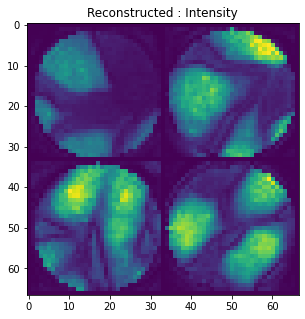

In [9]:
# Plotting the corresponding reconstructed images
pred_img_set = pred_out.unsqueeze(dim= 1)[10:14]
 

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(make_grid(pred_img_set.abs().detach().cpu(), nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY),vmin = 0, vmax =1)
plt.title('Reconstructed : Intensity')